# Demonstrating how to create surface (lat/lon) plots from CMIP6 data

by [Dianne Deauna](https://github.com/jdldeauna)
<br>
Surface plots are useful for looking at the spatial variability of a parameter. This notebook also demonstrates how we can calculate how they change in the future, depending on different emissions scenarios.

First, we import the packages we need for this example. To run a piece of code, click on the cell and hit `Shift` + `Enter`.

In [1]:
import intake
import matplotlib as plt
import xarray as xr
import numpy as np
import cftime
import dask
import xgcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import cmocean as cmo
import cmip6_preprocessing
from cmip6_preprocessing.preprocessing import combined_preprocessing

Open dask client

In [2]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()
cluster.adapt(minimum=2, maximum=10) 
client = cluster.get_client()
client

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.9477ba2cafbf47e49b9422403cd05081/status,


Next, we download oxygen (`o2`) for UKESM1-0-LL, one example of an [Earth System Model](https://pcmdi.llnl.gov/CMIP6/ArchiveStatistics/esgf_data_holdings/). ESMs are global, 4-dimensional, coupled ocean-atmosphere-biogeochemical models commonly used to evaluate the effects of increased atmospheric carbon dioxide concentrations on planetary processes. Check out [this page](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained) for further information. In this example, we are using both modeled historical and [future climate data](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change) under high to low climate change mitigation scenarios, so feel free to explore! You can also play around with the [variable](http://proj.badc.rl.ac.uk/svn/exarch/CMIP6dreq/tags/latest/dreqPy/docs/CMIP6_MIP_tables.xlsx) you want to work with. The latest version of these datasets are under CMIP6 and are hosted in the cloud by the [Pangeo project](https://pangeo.io/). 

In [3]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(
    source_id = 'UKESM1-0-LL', # use a different source ID if you want to try other models
    member_id = 'r1i1p1f2', # common values are r1i1p1f1 or r1i1p1f2
    experiment_id = ['historical','ssp585', 'ssp126'], 
    variable_id= ['o2'],
    grid_label = 'gn', # common values are gn or gr, must double check if you're changing the model you're working with 
    
)
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'use_cftime':True}, aggregate=False, preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


Now we're getting our data from the initial download dictionary, and we need to make sure we're selecting the right `key` when assigning values.

In [4]:
ddict.keys()

dict_keys(['CMIP.MOHC.UKESM1-0-LL.historical.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/o2/gn/v20190627/.nan.20190627', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp126.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r1i1p1f2/Omon/o2/gn/v20190708/.nan.20190708', 'ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/o2/gn/v20190726/.nan.20190726'])

In [5]:
var_historical = ddict['CMIP.MOHC.UKESM1-0-LL.historical.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Omon/o2/gn/v20190627/.nan.20190627']
var_future_585 = ddict['ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/Omon/o2/gn/v20190726/.nan.20190726']

`var_historical` and `var_future_585` are global in scope, so if we want to zoom in to a specific region, we need to subset according to latitude/longitude. The region we're using for this notebook is the California Current System, but feel free to experiment with the boundary values to focus on your own region. The last line lets you do a quick plot, which is a great practice to make sure we're getting the correct boundaries.

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

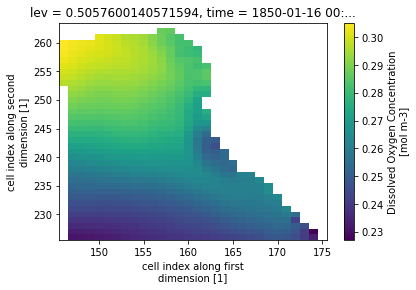

In [6]:
lat_north = 50
lat_south = 25
lon_west = 220
lon_east = 249.25

subset_historical = var_historical.where((var_historical.lat > lat_south) & (var_historical.lat < lat_north) & (var_historical.lon > lon_west) & (var_historical.lon < lon_east), drop=True)
subset_future_585 = var_future_585.where((var_future_585.lat > lat_south) & (var_future_585.lat < lat_north) & (var_future_585.lon > lon_west) & (var_future_585.lon < lon_east), drop=True)

varname = 'o2' # need to change if you selected a different variable
subset_historical[varname].isel(lev=0,time=0).squeeze().plot()

At this point we can subset even further in depth and time. The next line lets you look at the raw values for ocean oxygen depth (`lev`). Select the depth you would like to plot, and the index that it corresponds to, then assign that value to `lev_index` in the next cell. In this example we're plotting oxygen at 47.21189 m (roughly where the oxycline is for this region), which means `lev_index` is equal to 18.

In [7]:
subset_historical[varname].lev

<xarray.DataArray 'lev' (lev: 75)>
array([5.057600e-01, 1.555855e+00, 2.667682e+00, 3.856280e+00, 5.140361e+00,
       6.543034e+00, 8.092519e+00, 9.822750e+00, 1.177368e+01, 1.399104e+01,
       1.652532e+01, 1.942980e+01, 2.275762e+01, 2.655830e+01, 3.087456e+01,
       3.574020e+01, 4.118002e+01, 4.721189e+01, 5.385064e+01, 6.111284e+01,
       6.902168e+01, 7.761116e+01, 8.692943e+01, 9.704131e+01, 1.080303e+02,
       1.200000e+02, 1.330758e+02, 1.474062e+02, 1.631645e+02, 1.805499e+02,
       1.997900e+02, 2.211412e+02, 2.448906e+02, 2.713564e+02, 3.008875e+02,
       3.338628e+02, 3.706885e+02, 4.117939e+02, 4.576256e+02, 5.086399e+02,
       5.652923e+02, 6.280260e+02, 6.972587e+02, 7.733683e+02, 8.566790e+02,
       9.474479e+02, 1.045854e+03, 1.151991e+03, 1.265861e+03, 1.387377e+03,
       1.516364e+03, 1.652568e+03, 1.795671e+03, 1.945296e+03, 2.101027e+03,
       2.262422e+03, 2.429025e+03, 2.600380e+03, 2.776039e+03, 2.955570e+03,
       3.138565e+03, 3.324641e+03, 3.513446e+03, 3.704657e+03, 3.897982e+03,
       4.093159e+03, 4.289953e+03, 4.488155e+03, 4.687581e+03, 4.888070e+03,
       5.089479e+03, 5.291683e+03, 5.494575e+03, 5.698061e+03, 5.902058e+03])
Coordinates:
  * lev      (lev) float64 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Attributes:
    axis:           Z
    bounds:         lev_bnds
    long_name:      ocean depth coordinate
    positive:       down
    standard_name:  depth
    units:          m

We're also getting the time-averaged mean for the last 30 years from each scenario, a period long enough to capture mean environmental conditions.

In [8]:
lev_index = 18
time_min_hist = '1985'
time_max_hist = '2014'
time_min_ssp = '2071'
time_max_ssp = '2100'

hist_mean = subset_historical[varname].isel(lev=lev_index).sel(time=slice(time_min_hist,time_max_hist)).mean(dim='time').squeeze()
future_mean_585 = subset_future_585[varname].isel(lev=lev_index).sel(time=slice(time_min_ssp,time_max_ssp)).mean(dim='time').squeeze()

When using biogeochemical data, it's easier to interpret the results when converting units to mmol m^-3. If using data such as temperature or salinity, you can comment out the following cell. In any case, just make sure your units are correct.

In [9]:
#Convert units of biogeochem data to mmol m^-3
hist_mean = hist_mean*1000
future_mean_585 = future_mean_585*1000

Plot the mean historical oxygen conditions

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


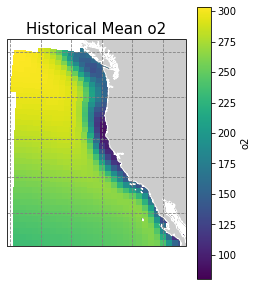

In [10]:
fig_size_height = 5
fig_size_width = 4

plt.figure(figsize=(fig_size_width,fig_size_height))
ax = plt.axes(projection=ccrs.Mercator())
hist_mean.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.coastlines()
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)
ax.set_title('Historical Mean ' + varname, fontsize=15)
ax.gridlines(linestyle='--',color='#808080') 

Plot the mean oxygen conditions under a future scenario

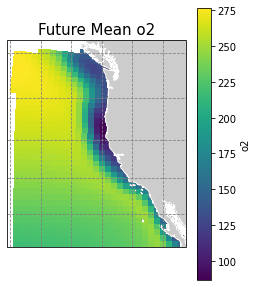

In [11]:
plt.figure(figsize=(fig_size_width,fig_size_height))
ax = plt.axes(projection=ccrs.Mercator())
future_mean_585.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.coastlines()
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)
ax.set_title('Future Mean ' + varname, fontsize=15)
ax.gridlines(linestyle='--',color='#808080') 

What's the difference in oxygen for the CCS region between a high-emission future scenario (`ssp585`) and the historical mean? 

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


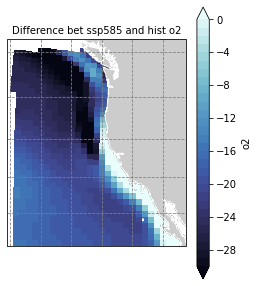

In [12]:
diff_mean = future_mean_585-hist_mean
vmin_in = -30
vmax_in = 0

plt.figure(figsize=(fig_size_width,fig_size_height))
ax = plt.axes(projection=ccrs.Mercator())
diff_mean.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=vmin_in, vmax=vmax_in, cmap=cmo.cm.ice, levels=31)
ax.coastlines()
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)
ax.set_title('Difference bet ssp585 and hist ' + varname, fontsize=10)
ax.gridlines(linestyle='--',color='#808080') 

What if we calculated the difference between a low-emission future scenario (`ssp126`) and the historical mean?

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1232: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


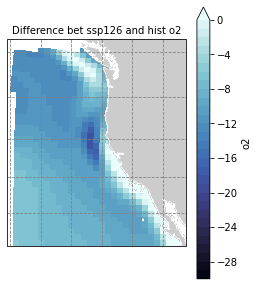

In [13]:
var_future_126 = ddict['ScenarioMIP.MOHC.UKESM1-0-LL.ssp126.r1i1p1f2.Omon.o2.gn.gs://cmip6/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp126/r1i1p1f2/Omon/o2/gn/v20190708/.nan.20190708']
subset_future_126 = var_future_126.where((var_future_126.lat > lat_south) & (var_future_126.lat < lat_north) & (var_future_126.lon > lon_west) & (var_future_126.lon < lon_east), drop=True)
future_mean_126 = subset_future_126[varname].isel(lev=lev_index).sel(time=slice(time_min_ssp,time_max_ssp)).mean(dim='time').squeeze()
future_mean_126 = future_mean_126*1000

diff_mean_126 = future_mean_126-hist_mean
vmin_in = -30
vmax_in = 0

plt.figure(figsize=(fig_size_width,fig_size_height))
ax = plt.axes(projection=ccrs.Mercator())
diff_mean_126.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=vmin_in, vmax=vmax_in, cmap=cmo.cm.ice, levels=31)
ax.coastlines()
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)
ax.set_title('Difference bet ssp126 and hist ' + varname, fontsize=10)
ax.gridlines(linestyle='--',color='#808080') 

#### What are the differences we can observe between the impacts of a high or low emission scenario on oxygen? What about for other parameters that you might have tried to plot?